In [1]:
import xarray as xr
import numpy as np
import dask.array as da
import matplotlib.pyplot as plt
import rasterio
from rasterio.crs import CRS
import os
from dask.distributed import Client, LocalCluster
from datetime import datetime,timedelta
import glob
import indices_function as ifun
import warnings
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import geopandas as gpd
warnings.filterwarnings('ignore')

In [3]:
!rm ./plot/*

In [2]:
cluster = LocalCluster(
    n_workers=10, 
    threads_per_worker=1,
    timeout='3600s',
    memory_limit='5GB',
)
client = Client(cluster)
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 10
Total threads: 10,Total memory: 46.57 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44319,Workers: 10
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 46.57 GiB
Comm: tcp://127.0.0.1:39611,Total threads: 1
Dashboard: http://127.0.0.1:43113/status,Memory: 4.66 GiB
Nanny: tcp://127.0.0.1:38267,


In [22]:
# Define intervals with non-linear spacing
intervals = [0, 0.2, 0.4, 0.6, 0.8, 1, 2, 4, 6, 8, 10, 12, 14]

# Select 20 colors from YlGn colormap
colors = plt.cm.YlGn(np.linspace(0, 1, 13))

# Create a custom colormap with specified intervals and colors
cmap= mcolors.ListedColormap(colors)
bounds = mcolors.BoundaryNorm(intervals, cmap.N)


In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Define color intervals and corresponding colors
intervals_diff= np.arange(-3, 3.5, 0.5)
colors_diff= plt.cm.PuOr(np.linspace(0, 1, len(intervals_diff) - 1))  # Use YlOrRd colormap

# Create a custom colormap with specified intervals and colors
cmap_diff= mcolors.ListedColormap(colors_diff)
bounds_diff= mcolors.BoundaryNorm(intervals_diff, cmap_diff.N)



/nobackupp10/datapool/NEX-DCP30-CMIP6/ACCESS-CM2
/nobackupp10/datapool/NEX-DCP30-CMIP6/ACCESS-ESM1-5
/nobackupp10/datapool/NEX-DCP30-CMIP6/BCC-CSM2-MR
/nobackupp10/datapool/NEX-DCP30-CMIP6/CMCC-ESM2
/nobackupp10/datapool/NEX-DCP30-CMIP6/CNRM-CM6-1
/nobackupp10/datapool/NEX-DCP30-CMIP6/CNRM-ESM2-1
/nobackupp10/datapool/NEX-DCP30-CMIP6/CanESM5
/nobackupp10/datapool/NEX-DCP30-CMIP6/EC-Earth3
/nobackupp10/datapool/NEX-DCP30-CMIP6/EC-Earth3-Veg-LR
/nobackupp10/datapool/NEX-DCP30-CMIP6/FGOALS-g3
/nobackupp10/datapool/NEX-DCP30-CMIP6/GFDL-CM4
/nobackupp10/datapool/NEX-DCP30-CMIP6/GFDL-ESM4
/nobackupp10/datapool/NEX-DCP30-CMIP6/GISS-E2-1-G
/nobackupp10/datapool/NEX-DCP30-CMIP6/HadGEM3-GC31-LL
/nobackupp10/datapool/NEX-DCP30-CMIP6/HadGEM3-GC31-MM
/nobackupp10/datapool/NEX-DCP30-CMIP6/INM-CM4-8
/nobackupp10/datapool/NEX-DCP30-CMIP6/INM-CM5-0
/nobackupp10/datapool/NEX-DCP30-CMIP6/IPSL-CM6A-LR
/nobackupp10/datapool/NEX-DCP30-CMIP6/KACE-1-0-G
/nobackupp10/datapool/NEX-DCP30-CMIP6/KIOST-ESM
/nobacku

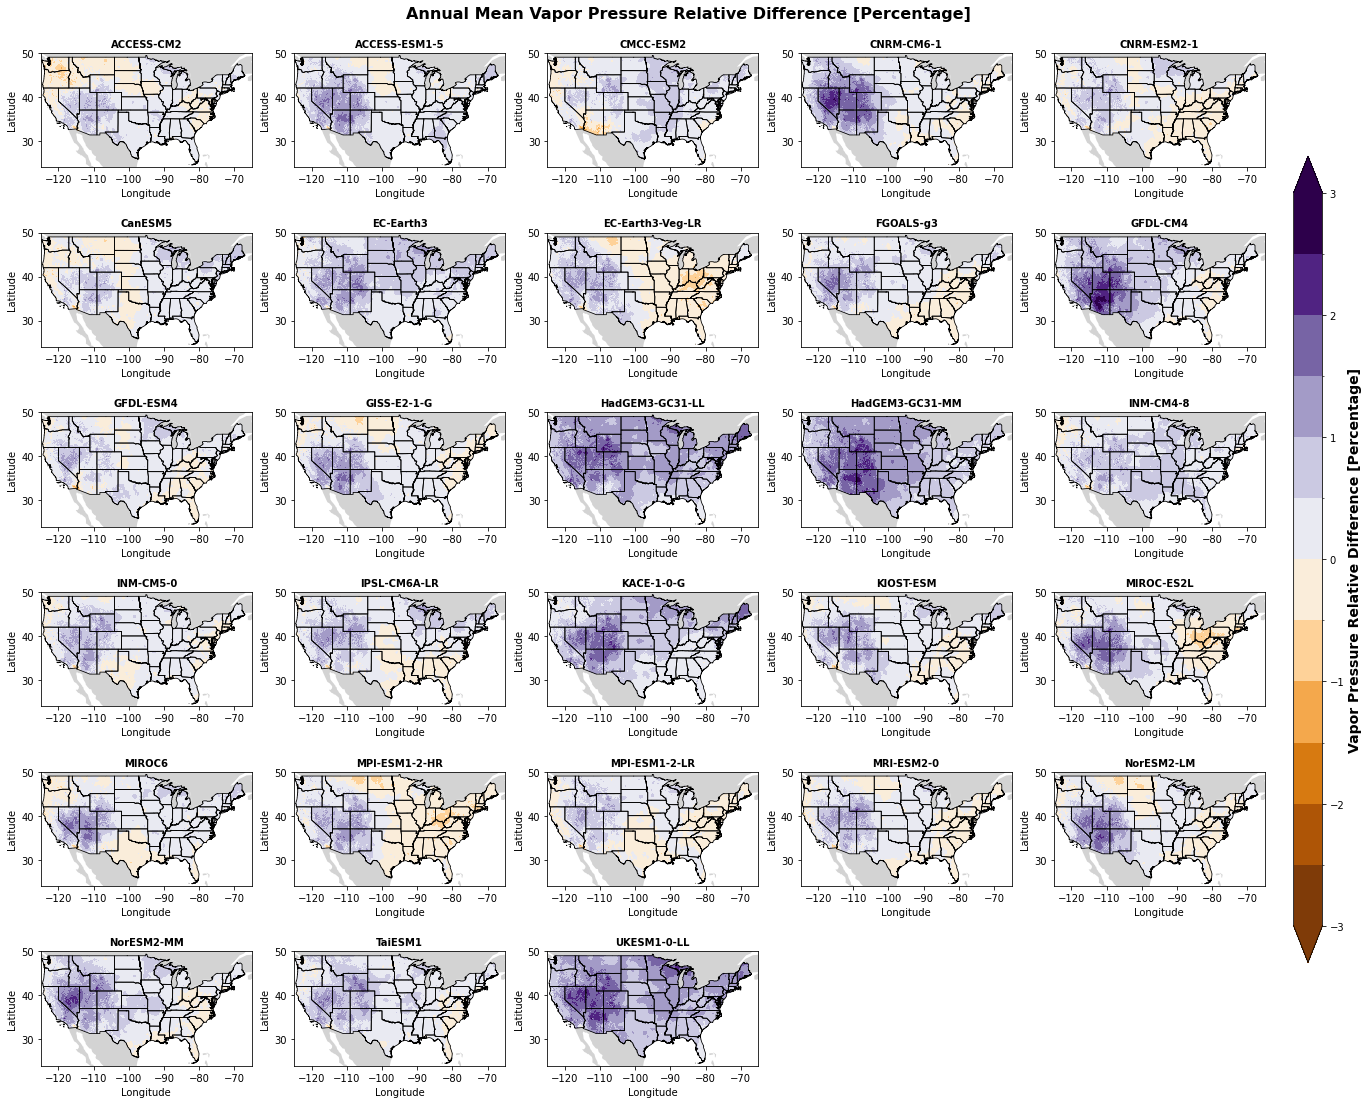

In [4]:
# import glob
# import xarray as xr
# import geopandas as gpd
# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors

# Load models
models = glob.glob("/nobackupp10/datapool/NEX-DCP30-CMIP6/*")
models.sort()
var = "vpr"

# Set up the figure and axes
fig, axs = plt.subplots(nrows=6, ncols=5, figsize=(20, 16), subplot_kw={'projection': None})

# Load geographic data
usa_states = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
states = gpd.read_file("conus.geojson")

# Custom colormap and normalization
# cmap_diff = plt.get_cmap('coolwarm')  # Example colormap, you may need to adjust
# bounds_diff = mcolors.Normalize(vmin=-5, vmax=1)  # Adjust these values as needed
# intervals = 11  # Number of intervals, adjust as needed

# Iterate through models and plot each one in a subplot
# Iterate through models and plot each one in a subplot
count=0
for i, model in enumerate(models):
    print(model)
    if model in ["/nobackupp10/datapool/NEX-DCP30-CMIP6/BCC-CSM2-MR","/nobackupp10/datapool/NEX-DCP30-CMIP6/NESM3"]:
        # count=count-1
        continue
    else:
        row = count // 5
        col = count % 5
        ax = axs[row, col]
        DCP = xr.open_zarr(f"/nobackupp28/skhajehe/dcp-indices/multimodel/single/vpr/{model.split('/')[-1]}.zarr")
        PRISM = xr.open_zarr(f"/nobackupp28/skhajehe/dcp-indices/prism/annual_average/{var}/2014.zarr")
        PRISM = PRISM.where(DCP[var].notnull())
        DCP['lon'] = (DCP['lon'] + 180) % 360 - 180
        DCP = DCP.sortby(DCP.lon)
        PRISM['lon'] = (PRISM['lon'] + 180) % 360 - 180
        PRISM = PRISM.sortby(PRISM.lon)
        DCP.load()
        PRISM.load()

        usa_states[usa_states['continent'] == 'North America'].plot(ax=ax, edgecolor='none', facecolor='lightgrey', linewidth=0.8)

        plot = (((DCP - PRISM) / PRISM) * 100).vpr.plot(ax=ax, cmap=cmap_diff, norm=bounds_diff, levels=intervals_diff, add_colorbar=False)

        states.boundary.plot(ax=ax, linewidth=0.8, color='black')
        ax.set_xlim(-125, -65)
        ax.set_ylim(24, 50)
        ax.set_title(model.split("/")[-1], fontsize=10, fontweight='bold')
        ax.set_xlabel("Longitude", fontsize=10)
        ax.set_ylabel("Latitude", fontsize=10)
        count=count+1
for i in range(3, 5):
    fig.delaxes(axs[5, i])
# Add the single colorbar on the right side of the figure
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(plot, cax=cax, orientation='vertical', extend='both')
cbar.set_label('Vapor Pressure Relative Difference [Percentage]', fontweight='bold', fontsize=14)

# Adjust layout and save the figure
plt.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.05, wspace=0.2, hspace=0.3)
plt.suptitle('Annual Mean Vapor Pressure Relative Difference [Percentage]', fontweight='bold', fontsize=16)
plt.savefig("./plot/all_vpr_relative_diff.png", dpi=300)
plt.show()